# Table of Contents
 <p>

In [121]:
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numba
import maxentropy
from matplotlib import rc

# plotting settings
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


In [200]:
def Energy_no_v(sigma, h, J):
    return -np.sum(h*sigma) - 1/2*J.dot(sigma).T.dot(sigma)

def Energy(sigma, h, J, Vk):
    return -np.sum(h.dot(sigma)) - 1/2*J.dot(sigma).T.dot(sigma) + Vk

def logP(sigma, h=h, J=J, Vk=None):
    if len(h) != len(sigma):
        raise ValueError('length of h must equal length of sigma')
    if len(J) != len(sigma):
        raise ValueError('length of J must equal length of sigma')
    return Energy(sigma, h, J, Vk)

def P(sigma, h, J, Vk=None):
    num = np.exp(logP(sigma, h, J, Vk))
    Z = 1 + num
    return num/Z

In [310]:
def monte_carlo(n_sim, t, params, burnin=3000):
    h, J = params
    S = np.empty((n_sim, t))
    H = np.empty((n_sim, t + burnin))
    sigma_prev = np.random.randint(0, 2, n_sim)
    sigma = sigma_prev
    E_prev = Energy_no_v(sigma, h, J)
    for i in np.arange(burnin + t):
        for j in np.arange(n_sim):
            sigma[j] = np.random.randint(0, 2, 1)
            E = Energy_no_v(sigma, h, J)
            DeltaE = E - E_prev

            # accept
            if DeltaE < 0:
                E_prev = E
            else:
                stick = np.random.uniform(0, 1)
                if -DeltaE > np.log(stick):
                    sigma[j] = sigma_prev[j]
                else:
                    E_prev = E
            H[j, i] = E_prev

        sigma_prev = sigma
        if i == burnin:
            print('burn-in finished')
        if (i > burnin) & (i%100 == 0):
            print('finished iteration {0}'.format(i))

        if i >= burnin:
            S[:, i - burnin] = sigma
    return S, H

In [435]:
n = 50
blocks = 10
blocksize = np.int(n/blocks)
sigma_i = np.random.randint(0, 2, (n))
h = -np.random.exponential(3, n)
# J = np.random.normal(0, 1, (n, n)) - np.random.exponential(3, (n, n))

mu = np.random.randint(-5, 3, blocks*blocks)
J = np.zeros((n, n))
X = [[None]*blocks]*blocks

A = None
for i in np.arange(blocks):
    for j in np.arange(blocks):
        mu = np.random.randint(-5, 3)
        Jsub = np.random.normal(mu, .01, (blocksize, blocksize))
        if A is not None:
            A = np.block([A, Jsub])
        else:
            A = Jsub

J = np.bmat(A)
J = J.reshape(-2, n)
J = (J + J.T)/2

J = np.random.normal(J, 0.5)

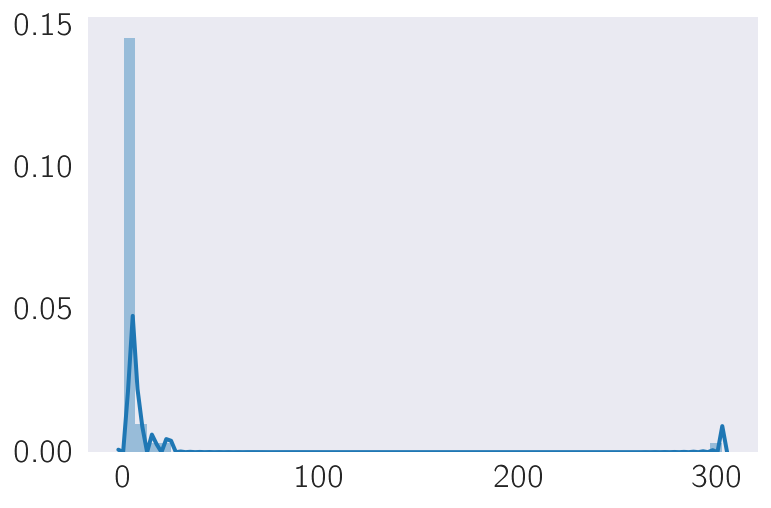